In [0]:
Lien vers la présentation:
https://docs.google.com/presentation/d/1ba5CuYwz-0VxYNFxpkQghF8ByfOnT1rilmy_nlF-jGQ/edit?usp=sharing

In [0]:
# first we have to install some libraries in Colab
!pip install zarr
!pip install gcsfs
!apt-get -qq install python-cartopy python3-cartopy

In [0]:
# general setup
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import zarr
import gcsfs
from matplotlib.dates import date2num

# set up cartopy
import cartopy.crs as ccrs
from matplotlib.axes import Axes
from cartopy.mpl.geoaxes import GeoAxes
GeoAxes._pcolormesh_patched = Axes.pcolormesh

# notebook display options
xr.set_options(display_style='html')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [0]:
# find the SSH data for given choices
df = pd.read_csv('https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv')
df_sst = df.query("activity_id=='ScenarioMIP' & table_id == 'Omon' & variable_id == 'tos' & experiment_id == 'ssp245' & institution_id == 'IPSL'")

# setup the gcs access
gcs = gcsfs.GCSFileSystem(token='anon')

# get the path to a specific zarr store (the first one from the dataframe above)
zstore = df_sst.zstore.values[-1]

# create a mapping interface to the store
mapper = gcs.get_mapper(zstore)

# open it using xarray and zarr
ds = xr.open_zarr(mapper, consolidated=True)

We'll select only the Northern Hemisphere:

In [0]:
ds=ds.sel(y=slice(180,255), x = slice(200,280))

Now let's see what happens if we try to plot a map for a specific date

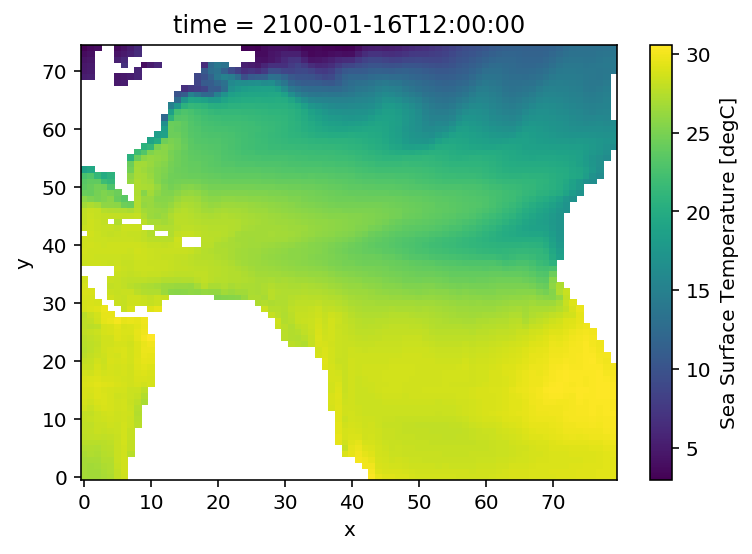

In [0]:
ds.tos.sel(time='2100-01').squeeze().plot()

In [0]:
sla_timeseries = ds.tos.mean(dim=('y', 'x')).load()

<xarray.DataArray 'tos' (time: 1032)>
array([22.095482, 21.663057, 21.56804 , ..., 26.95176 , 25.845087,
       24.718958], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 2015-01-16T12:00:00 ... 2100-12-16T12:00:00

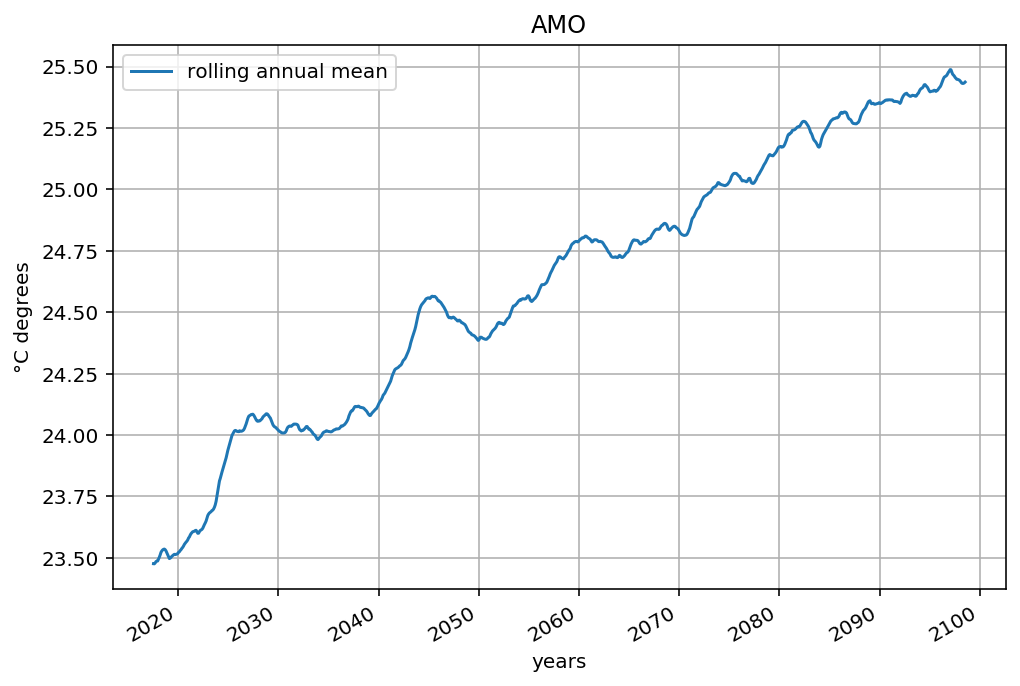

In [0]:
#sla_timeseries.plot(label='full data')
sla_timeseries.rolling(time=60, center=True).mean().plot(label='rolling annual mean')
plt.legend()
plt.title('AMO')
plt.xlabel('years')
plt.ylabel('°C degrees')  
plt.grid()

It's very difficult to see what's going on in the Arctic with this projection. We'll manage this by using the Polar Stereographic projection, which has the North Pole in the middle of the figure, like this:

In [0]:
import numpy as np
from sklearn.linear_model import LinearRegression

X = np.array([[735614 + 60*i] for i in range(516)])
Y = []
for i in range(0,1031,2) :
  Y.append([(sla_timeseries.values[i] + sla_timeseries.values[i+1])/2])
Y = np.array(Y)

model = LinearRegression()
model.fit(X,Y)

ypred = model.predict(X)

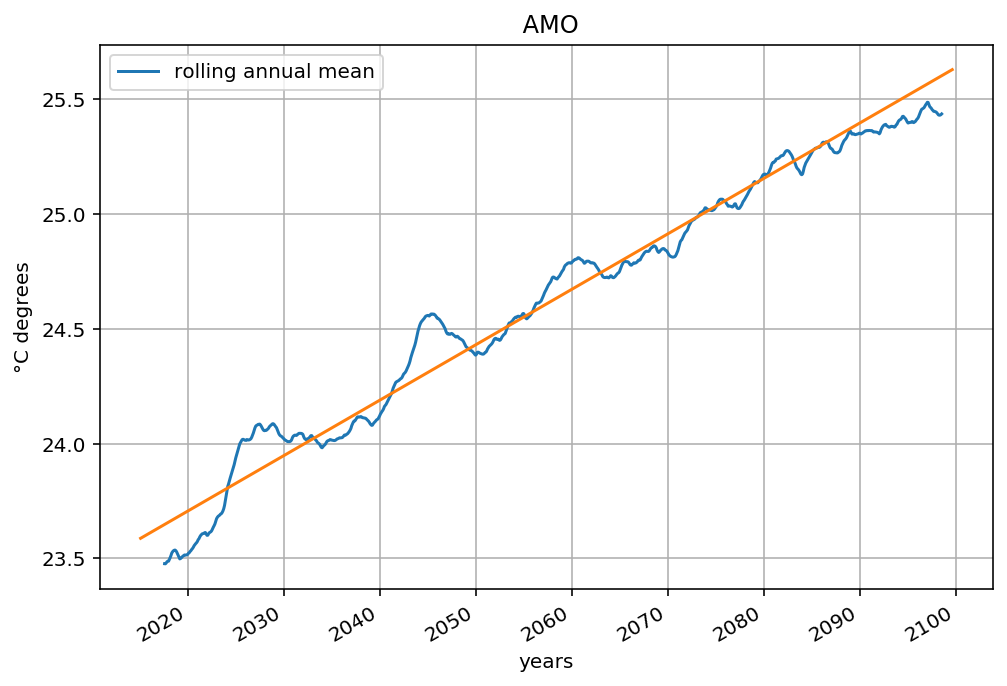

In [0]:
sla_timeseries.rolling(time=60, center=True).mean().plot(label='rolling annual mean')
plt.plot(X, ypred)
plt.legend()
plt.title(' AMO')
plt.xlabel('years')
plt.ylabel('°C degrees')
plt.grid()

In [0]:
from matplotlib.dates import num2date

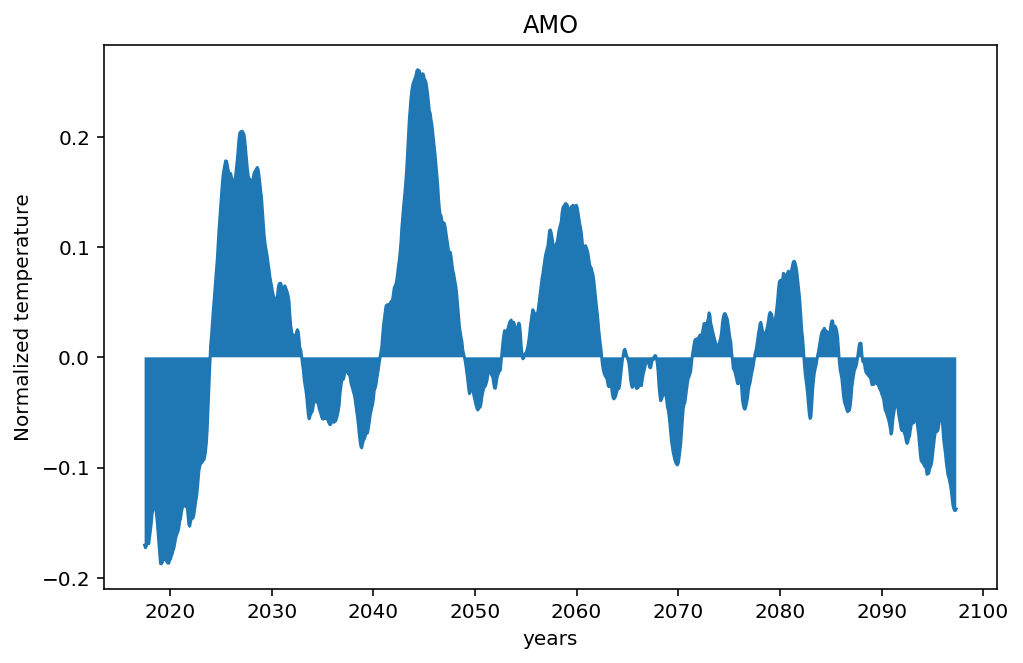

In [0]:
sla3 = []
for i in range(len(sla_timeseries.rolling(time=60, center=True).mean().values)) :
  sla3.append(sla_timeseries.rolling(time=60, center=True).mean()[i] - model.predict(np.array([[735614 + 30*i]]))[0][0])

X3 = np.array([[num2date(735614 + 30*i)] for i in range(1032)])
plt.plot(list(X3.T[0]), sla3)
plt.fill_between(list(X3.T[0]), 0, sla3)
plt.title('AMO')
plt.xlabel('years')
plt.ylabel('Normalized temperature')
plt.show()

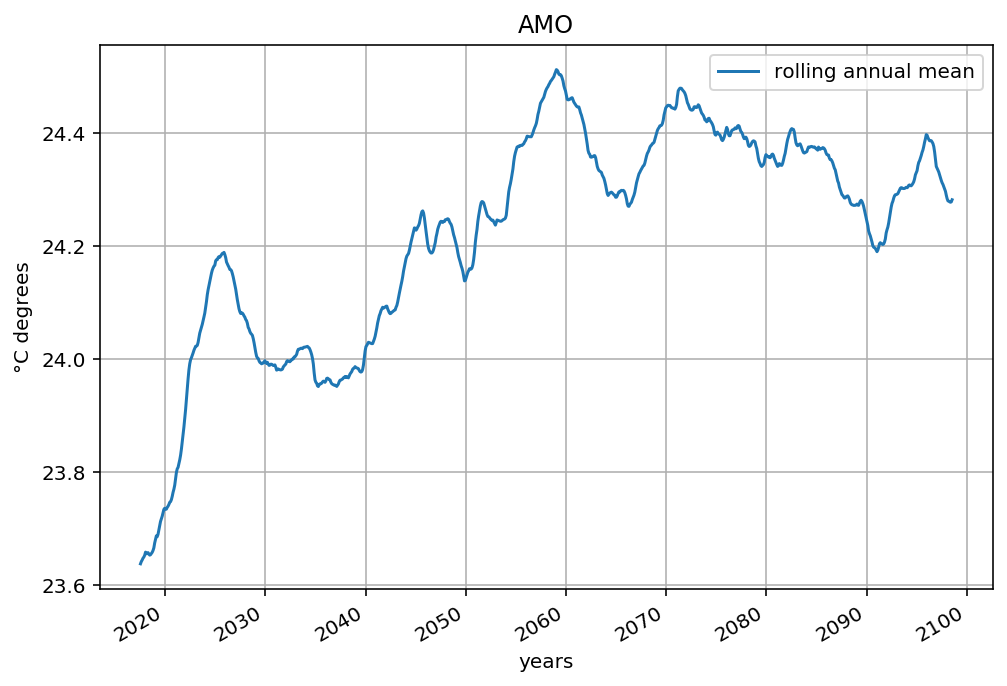

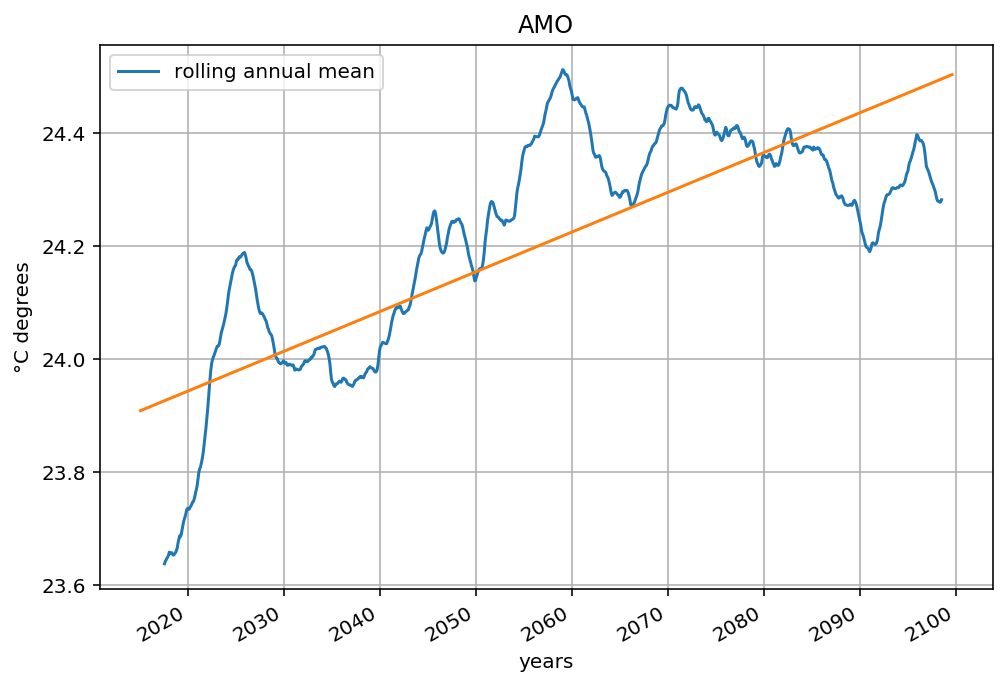

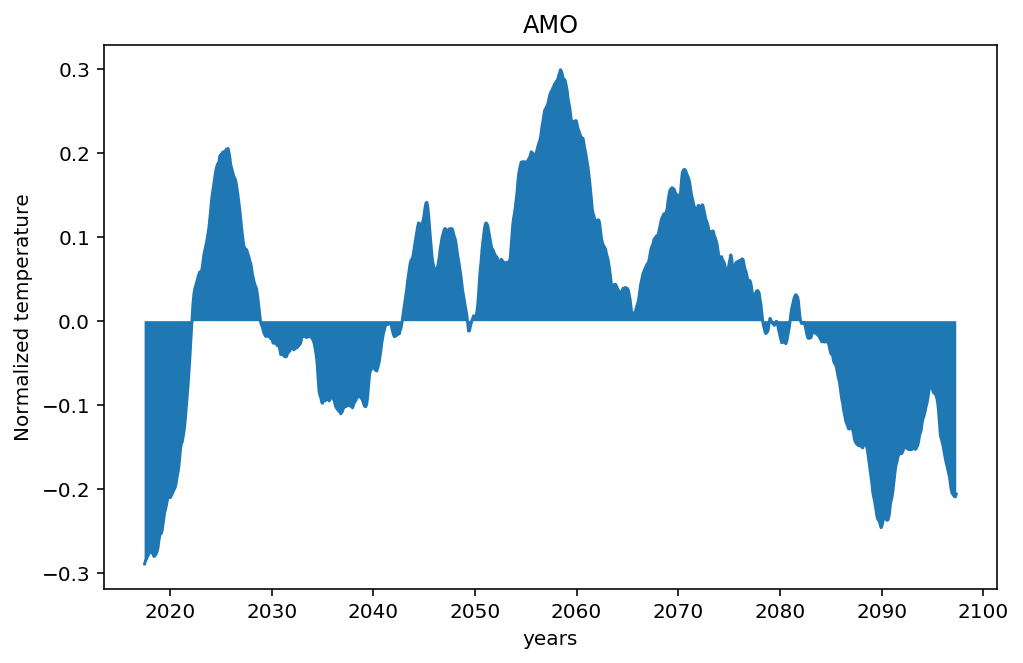

In [0]:
df = pd.read_csv('https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv')
df_sst = df.query("activity_id=='ScenarioMIP' & table_id == 'Omon' & variable_id == 'tos' & experiment_id == 'ssp126' & institution_id == 'IPSL'")
def plot_AMO(df_sst): 
  # setup the gcs access
  gcs = gcsfs.GCSFileSystem(token='anon')

  # get the path to a specific zarr store (the first one from the dataframe above)
  zstore = df_sst.zstore.values[-1]

  # create a mapping interface to the store
  mapper = gcs.get_mapper(zstore)

  # open it using xarray and zarr
  ds = xr.open_zarr(mapper, consolidated=True)
  ds=ds.sel(y=slice(180,255), x = slice(200,280))
  sla_timeseries = ds.tos.mean(dim=('y', 'x')).load()
  sla_timeseries.rolling(time=60, center=True).mean().plot(label='rolling annual mean')
  plt.legend()
  plt.grid()
  plt.title('AMO')
  plt.xlabel('years')
  plt.ylabel('°C degrees')
  plt.show()
  X = np.array([[735614 + 60*i] for i in range(516)])
  Y = []
  for i in range(0,1031,2) :
    Y.append([(sla_timeseries.values[i] + sla_timeseries.values[i+1])/2])
  Y = np.array(Y)

  model = LinearRegression()
  model.fit(X,Y)

  ypred = model.predict(X)

  sla_timeseries.rolling(time=60, center=True).mean().plot(label='rolling annual mean')
  plt.plot(X, ypred)
  plt.legend()
  plt.grid()
  plt.title('AMO')
  plt.xlabel('years')
  plt.ylabel('°C degrees')
  plt.show()

  sla3 = []
  for i in range(len(sla_timeseries.rolling(time=60, center=True).mean().values)) :
    sla3.append(sla_timeseries.rolling(time=60, center=True).mean().values[i] - model.predict(np.array([[735614 + 30*i]]))[0][0])

  X3 = np.array([[num2date(735614 + 30*i)] for i in range(1032)])
  plt.plot(list(X3.T[0]), sla3)
  plt.fill_between(list(X3.T[0]), 0, sla3)
  plt.title('AMO')
  plt.xlabel('years')
  plt.ylabel('Normalized temperature')
  plt.show()
  return sla3
results = plot_AMO(df_sst)


In [0]:
df = pd.read_csv('https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv')
df_sst = df.query("activity_id=='ScenarioMIP' & table_id == 'Omon' & variable_id == 'tos' & experiment_id == 'ssp245' & institution_id == 'IPSL'")
def plot_AMO(df_sst): 
  # setup the gcs access
  gcs = gcsfs.GCSFileSystem(token='anon')

  # get the path to a specific zarr store (the first one from the dataframe above)
  zstore = df_sst.zstore.values[-1]

  # create a mapping interface to the store
  mapper = gcs.get_mapper(zstore)

  # open it using xarray and zarr
  ds = xr.open_zarr(mapper, consolidated=True)
  ds=ds.sel(y=slice(180,255), x = slice(200,280))
  sla_timeseries = ds.tos.mean(dim=('y', 'x')).load()
  X = np.array([[735614 + 60*i] for i in range(516)])
  Y = []
  for i in range(0,1031,2) :
    Y.append([(sla_timeseries.values[i] + sla_timeseries.values[i+1])/2])
  Y = np.array(Y)

  model = LinearRegression()
  model.fit(X,Y)

  ypred = model.predict(X)

  sla3 = []
  for i in range(len(sla_timeseries.rolling(time=60, center=True).mean().values)) :
    sla3.append(sla_timeseries.rolling(time=60, center=True).mean().values[i] - model.predict(np.array([[735614 + 30*i]]))[0][0])
  
  return sla3

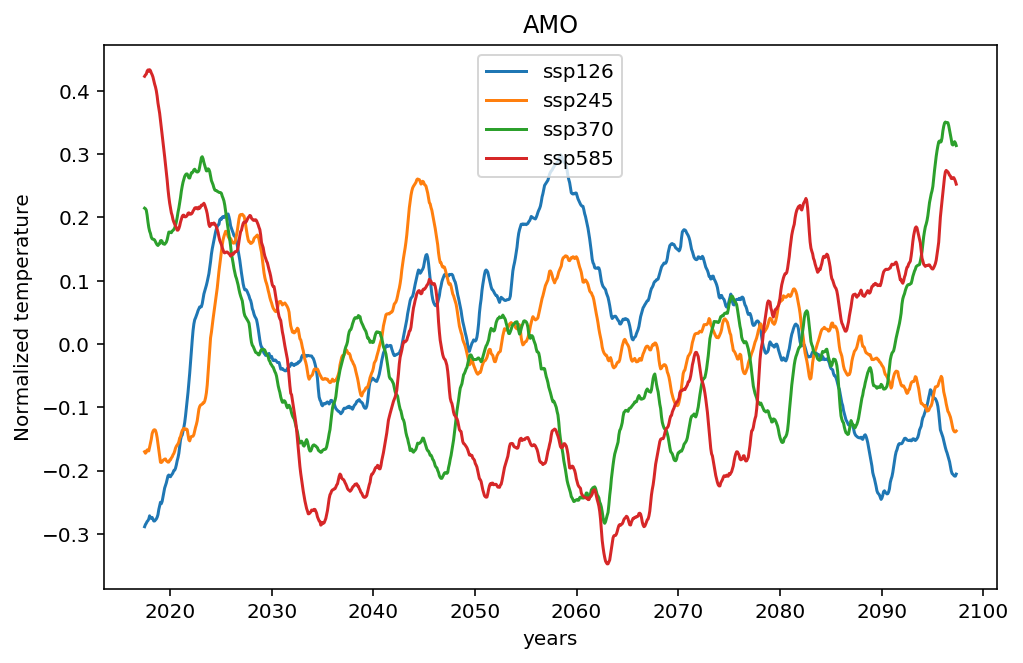

In [0]:
plots = []
df_sst = df.query("activity_id=='ScenarioMIP' & table_id == 'Omon' & variable_id == 'tos' & experiment_id == 'ssp126' & institution_id == 'IPSL'")
plots.append(plot_AMO(df_sst))
df_sst = df.query("activity_id=='ScenarioMIP' & table_id == 'Omon' & variable_id == 'tos' & experiment_id == 'ssp245' & institution_id == 'IPSL'")
plots.append(plot_AMO(df_sst))
df_sst = df.query("activity_id=='ScenarioMIP' & table_id == 'Omon' & variable_id == 'tos' & experiment_id == 'ssp370' & institution_id == 'IPSL'")
plots.append(plot_AMO(df_sst))
df_sst = df.query("activity_id=='ScenarioMIP' & table_id == 'Omon' & variable_id == 'tos' & experiment_id == 'ssp585' & institution_id == 'IPSL'")
plots.append(plot_AMO(df_sst))

x = np.array([[num2date(735614 + 30*i)] for i in range(1032)])

names = ['ssp126', 'ssp245', 'ssp370', 'ssp585']
for i in range(len(plots)) :
  plt.plot(x, plots[i], label = names[i])
plt.legend()
plt.title('AMO')
plt.xlabel('years')
plt.ylabel('Normalized temperature')
plt.show()

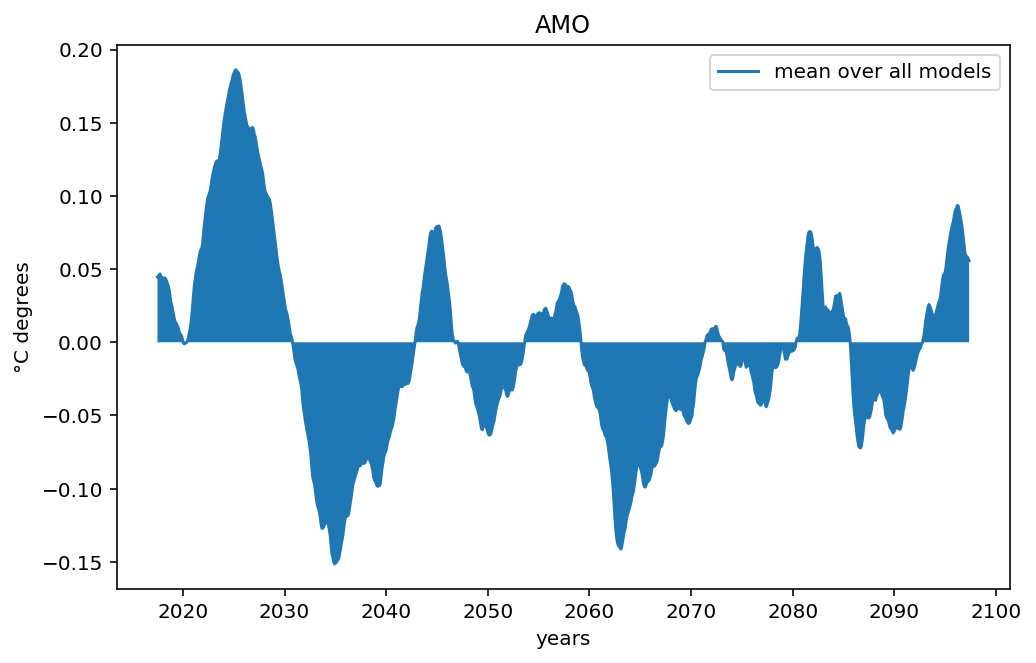

In [0]:
average_plot = np.array(plots).mean(axis = 0)
plt.plot(x, average_plot, label = 'mean over all models')
plt.legend()
plt.title('AMO')
plt.xlabel('years')
plt.ylabel('°C degrees')
plt.fill_between(list(x.T[0]), 0, average_plot)
plt.show()

In [0]:
df = pd.read_csv('https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv')
df_ta = df.query("activity_id=='CMIP' & table_id == 'Amon' & variable_id == 'ps' & institution_id == 'IPSL'")
# this only needs to be created once
gcs = gcsfs.GCSFileSystem(token='anon')

# get the path to a specific zarr store (the first one from the dataframe above)
zstore = df_ta.zstore.values[-1]

# create a mutable-mapping-style interface to the store
mapper = gcs.get_mapper(zstore)

# open it using xarray and zarr
ds = xr.open_zarr(mapper, consolidated=True,decode_times=True)

df_area = df.query("variable_id == 'areacella' & source_id == 'CESM2'")
ds_area = xr.open_zarr(gcs.get_mapper(df_area.zstore.values[0]), consolidated=True)
ta_timeseries = ds.ps.mean(dim=('lat', 'lon')).load()
#values = ta_timeseries.rolling(time=60).mean().values 
#l=[]
#for i in range(len(values)):
#  if values [i]<100000:
#    l.append(values[i])
#l=np.array(l)
#print(l.mean())
#l=(l-l.mean())/l.std()
#plt.plot(l)

No handles with labels found to put in legend.


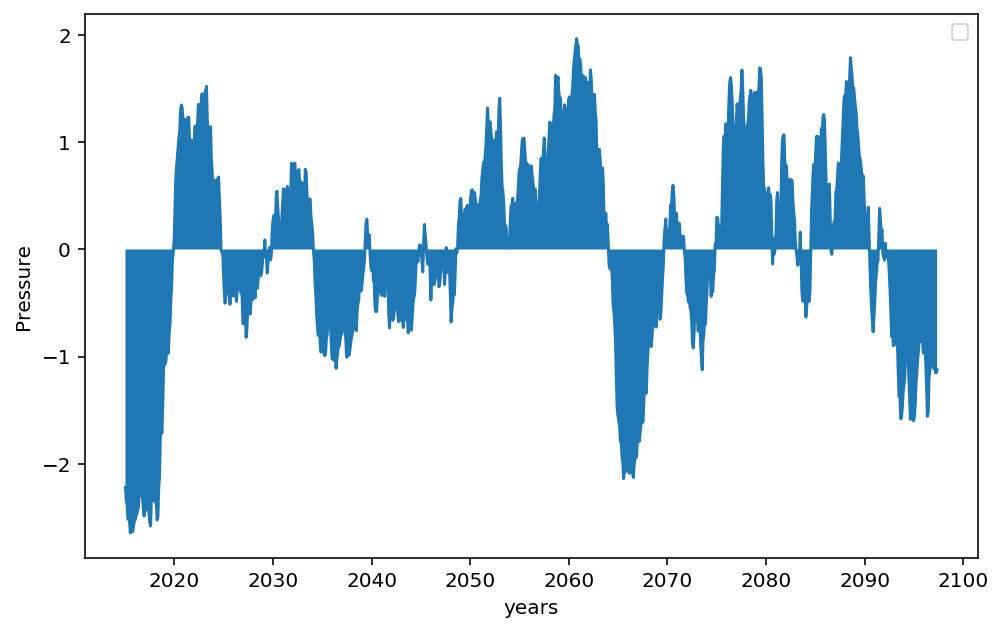

In [0]:
pressure = ta_timeseries.rolling(time=60, center=True).mean().values[-1032:]
real_pressure = []
for i in range(len(pressure)) :
  if pressure[i] < 10000000 :
    real_pressure.append(pressure[i])
real_pressure = np.array(real_pressure)
pressure = pressure - np.mean(real_pressure)
pressure = pressure/np.std(real_pressure)
x = np.array([[num2date(735614 + 30*i)] for i in range(1032)])
plt.rcParams['figure.figsize'] = (8, 5)
plt.plot(x, pressure)
plt.legend()
plt.xlabel('years')
plt.ylabel('Pressure')
plt.fill_between(list(x.T[0]), 0, pressure)
plt.show()

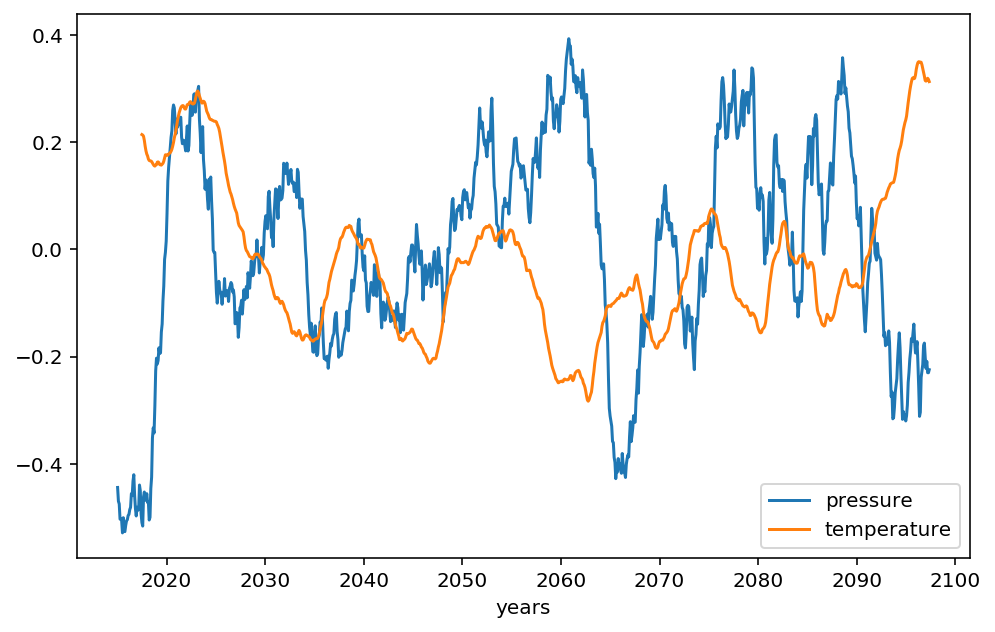

In [0]:
df_sst = df.query("activity_id=='ScenarioMIP' & table_id == 'Omon' & variable_id == 'tos' & experiment_id == 'ssp370' & institution_id == 'IPSL'")
to_plot = plot_AMO(df_sst)

plt.rcParams['figure.figsize'] = (8, 5)
plt.plot(x, pressure/5, label = 'pressure')
plt.plot(x, to_plot, label = 'temperature')
plt.legend()
plt.xlabel('years')
plt.ylabel('')
plt.show()